In [1]:
# Importing required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

import warnings

sns.set()
warnings.filterwarnings("ignore")

In [2]:
# Importing data and date lookup

import pandas as pd
import numpy as np
import json
with open(r'acn.json', 'r') as jf:
    ev = json.load(jf)
       
# Flatten data
df = pd.json_normalize(ev, record_path =['_items'])
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,0039,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,0002,CA-496,2-39-78-362,America/Los_Angeles,None,None
1,5bc90cb9f9af8b0d7fe77cd3,0039,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,0002,CA-319,2-39-95-27,America/Los_Angeles,None,None
2,5bc90cb9f9af8b0d7fe77cd4,0039,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,0002,CA-489,2-39-79-380,America/Los_Angeles,None,None
3,5bc90cb9f9af8b0d7fe77cd5,0039,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,0002,CA-327,2-39-79-379,America/Los_Angeles,None,None
4,5bc90cb9f9af8b0d7fe77cd6,0039,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,0002,CA-490,2-39-79-381,America/Los_Angeles,None,None


In [3]:
#Initial Data Preprocessing Steps
df_pre=df
def date_conversion(col):     
    date_connection_time = pd.to_datetime(df_pre[col], format="%a, %d %b %Y %X %Z")
    date_format_connect = date_connection_time.dt.tz_localize(None)
    connect_date = date_format_connect.dt.date
    df_pre[col] = connect_date
    df_pre[col]=df_pre[col].astype('datetime64[ns]')
df_pre['doneChargingTime'].fillna(df_pre['disconnectTime'],inplace=True) # Fill Null values
date_conversion('connectionTime')
date_conversion('disconnectTime')
date_conversion('doneChargingTime')
def ev_univ(input_col,pred_col):
    ev_univ = df_pre[[input_col,pred_col]]
    ev_univ_agg = ev_univ.groupby([input_col]).agg({pred_col:np.sum})
    return ev_univ_agg
uni_done = ev_univ('doneChargingTime','kWhDelivered')
uni_conn = ev_univ('connectionTime','kWhDelivered')
uni_disconn = ev_univ('disconnectTime','kWhDelivered')
uni_2=uni_disconn.reset_index()
df_1=uni_2
df_1

,disconnectTime,kWhDelivered
0,2018-04-25,151.103
1,2018-04-26,385.389
2,2018-04-27,409.963
3,2018-04-28,540.545
4,2018-04-29,267.643
...,...,...
1074,2021-09-10,393.768
1075,2021-09-11,315.598
1076,2021-09-12,179.279
1077,2021-09-13,368.374


In [4]:
#Importing Date Lookup table
      
# Flatten data
date_df = pd.read_csv(r'date_lookup.csv')
date_df.head()

,Date,Year,Month,Day
0,25-Apr-2018,2018,4,25
1,26-Apr-2018,2018,4,26
2,27-Apr-2018,2018,4,27
3,28-Apr-2018,2018,4,28
4,29-Apr-2018,2018,4,29


In [5]:
#Lookup Table processing
date_df['Date'] = date_df['Date'].astype('datetime64')
date_df.set_index('Date')
merge=pd.merge(date_df,df_1, how='left',left_on='Date',right_on='disconnectTime')
merge['day_of_week'] = merge['Date'].dt.weekday
merge["IsWeekend"] = merge["day_of_week"] >= 5
analy = merge[['Date','kWhDelivered']]
analy_weekend = merge[['Date','IsWeekend','kWhDelivered']]
analy_1=analy.set_index('Date')
analy_weekend_1=analy_weekend.set_index('Date')
#KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df = pd.DataFrame(imputer.fit_transform(analy_weekend_1),columns = analy_weekend_1.columns)
#Concatenating date lookup and source data
x1=pd.concat([analy_weekend,df], axis=1, ignore_index=True)
final=x1
final.drop(3,axis=1,inplace=True)
final.drop(2,axis=1,inplace=True)
final_df=final.rename(columns={0:'Date',1: "IsWeekend", 4: "kWhDelivered"})
uni_3=final_df
uni_3=uni_3.set_index('Date')
uni_3.index.freq = 'D'
uni_3_filter=uni_3['kWhDelivered']
uni_3.rename(columns={'kWhDelivered':'Kwh'},inplace=True)
uni_3_filter = uni_3
uni_3_filter = uni_3_filter.drop('IsWeekend',axis=1,inplace=True)
data=uni_3 # Data for forecastinng

In [6]:
data

,Kwh
Date,
2018-04-25,151.103
2018-04-26,385.389
2018-04-27,409.963
2018-04-28,540.545
2018-04-29,267.643
...,...
2021-09-10,393.768
2021-09-11,315.598
2021-09-12,179.279


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2018-04-25 to 2021-09-14
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Kwh     1239 non-null   float64
dtypes: float64(1)
memory usage: 19.4 KB


In [8]:
data_exo=final_df
data_exo = data_exo.set_index('Date')
data_exo.index.freq = 'D'
data_exo.drop('kWhDelivered',axis=1,inplace=True)
data_exo

,IsWeekend
Date,
2018-04-25,False
2018-04-26,False
2018-04-27,False
2018-04-28,True
2018-04-29,True
...,...
2021-09-10,False
2021-09-11,True
2021-09-12,True


In [9]:
data_exo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2018-04-25 to 2021-09-14
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   IsWeekend  1239 non-null   bool 
dtypes: bool(1)
memory usage: 10.9 KB


In [10]:
#Train and Test Split
train_df = data.loc[:"2020-12-31"]
test_df = data.loc["2021-01-01":]

In [11]:
train_df_exo=data_exo.loc["2018-04-26":"2020-12-31"]
test_df_exo=data_exo.loc["2021-01-01":]

In [12]:
test_df_exo

,IsWeekend
Date,
2021-01-01,False
2021-01-02,True
2021-01-03,True
2021-01-04,False
2021-01-05,False
...,...
2021-09-10,False
2021-09-11,True
2021-09-12,True


In [13]:
#Stationarity Check

def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, zero = False, lags = 40, ax = axes[0])
    sgt.plot_pacf(series, zero = False, lags = 40, ax = axes[1])

    plt.show()

# For Stationary check, ACF, PACF graph and ADFULLER test is incorporated

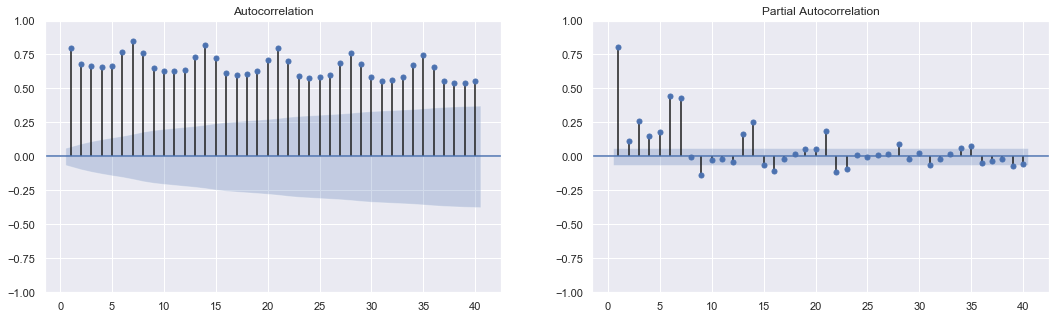

(-1.5030805590438363,
 0.5319868836812156,
 22,
 959,
 {'1%': -3.43718721587049,
  '5%': -2.8645585177815187,
  '10%': -2.568377225331392},
 11356.553737700688)

In [14]:
plot_acf_pacf(train_df["Kwh"])
adfuller(train_df["Kwh"])

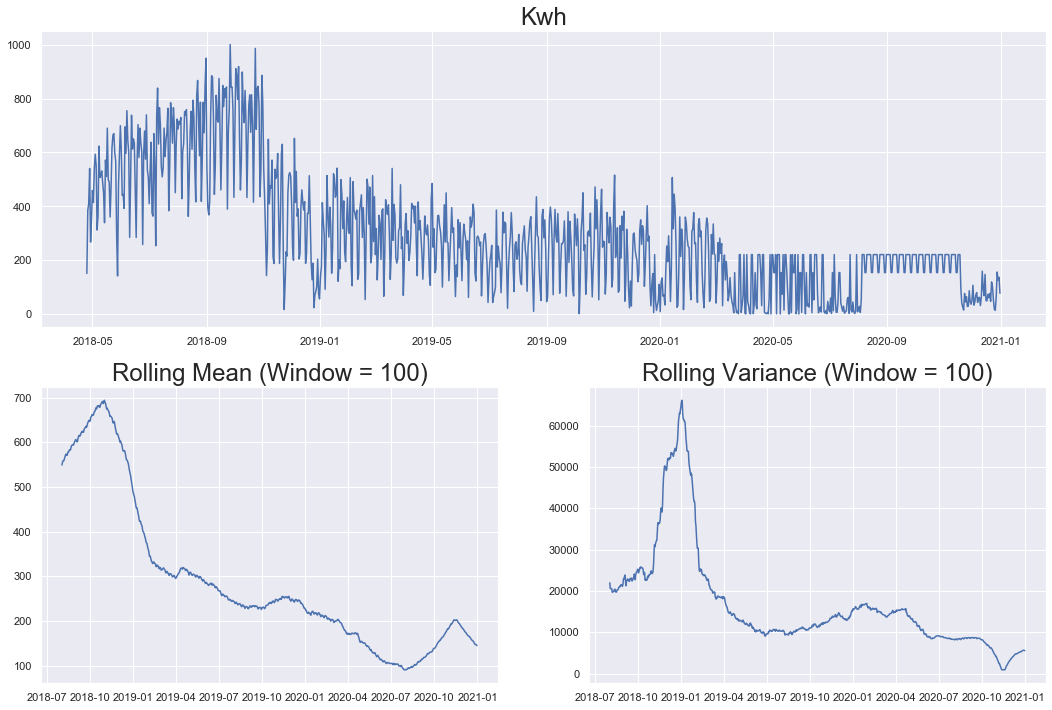

In [15]:
#Non-Stationary to Stationary

rolling_mean = train_df["Kwh"].rolling(100).mean()
rolling_var = train_df["Kwh"].rolling(100).var()

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(train_df["Kwh"])
plt.title("Kwh", size = 24)

plt.subplot(2, 2, 3)
plt.plot(rolling_mean)
plt.title("Rolling Mean (Window = 100)", size = 24)

plt.subplot(2, 2, 4)
plt.plot(rolling_var)
plt.title("Rolling Variance (Window = 100)", size = 24)

plt.show()

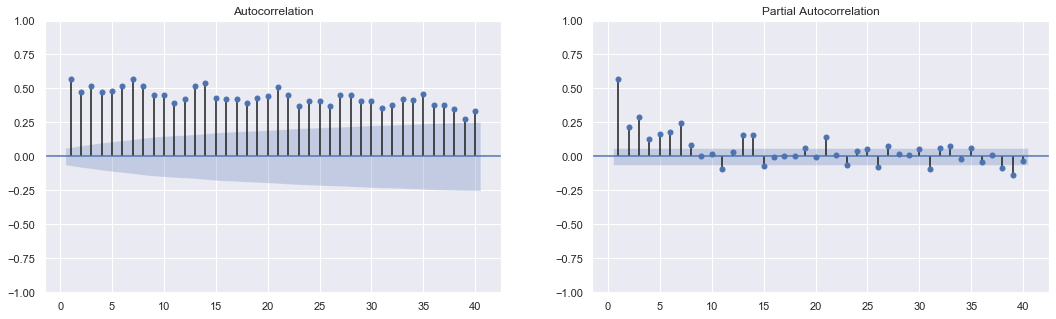

(-2.039902862243518,
 0.2693556564071585,
 20,
 961,
 {'1%': -3.4371729482129885,
  '5%': -2.8645522259969534,
  '10%': -2.568373874086242},
 2480.299270073993)

In [16]:
# Log Transformation

plot_acf_pacf(np.log(train_df["Kwh"].values))
adfuller(np.log(train_df["Kwh"].values))

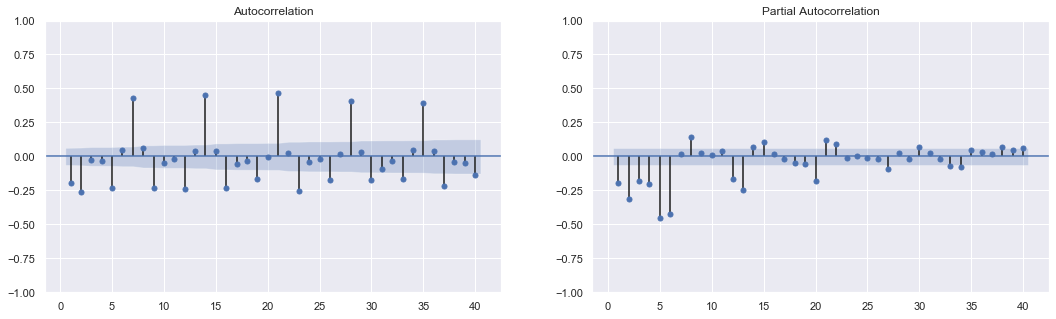

(-8.5364357062276,
 1.0050624916737852e-13,
 21,
 959,
 {'1%': -3.43718721587049,
  '5%': -2.8645585177815187,
  '10%': -2.568377225331392},
 11344.168965907375)

In [17]:
#Differencing Transformation

plot_acf_pacf(train_df["Kwh"].diff(1).dropna())
adfuller(train_df["Kwh"].diff(1).dropna())

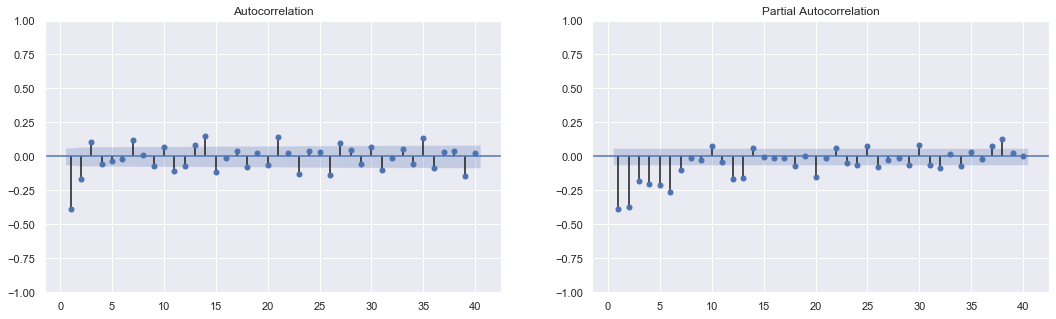

(-10.99630499077463,
 6.857474030243377e-20,
 19,
 961,
 {'1%': -3.4371729482129885,
  '5%': -2.8645522259969534,
  '10%': -2.568373874086242},
 2481.0660764329587)

In [18]:
# Log and Differencing
train_df["Kwh_log_diff"] = np.log(train_df["Kwh"].values)
train_df["Kwh_log_diff"] = train_df["Kwh_log_diff"].diff(1)

plot_acf_pacf(train_df["Kwh_log_diff"].dropna())
adfuller(train_df["Kwh_log_diff"].dropna())

# Since the p-value is <0.05, the dataset is now stationary.

In [19]:
train_df["Kwh_log_diff"]

Date
2018-04-25         NaN
2018-04-26    0.936291
2018-04-27    0.061814
2018-04-28    0.276511
2018-04-29   -0.702924
                ...   
2020-12-27    1.524788
2020-12-28    0.862776
2020-12-29   -0.212483
2020-12-30    0.077562
2020-12-31   -0.566413
Freq: D, Name: Kwh_log_diff, Length: 982, dtype: float64

In [20]:
#Model Building

#ARMA - (1,0,1)
#ARIMA - (1,1,1)
model = SARIMAX(train_df["Kwh_log_diff"].dropna(), order = (1, 0, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Kwh_log_diff   No. Observations:                  981
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1301.035
Date:                Fri, 12 Aug 2022   AIC                           2608.070
Time:                        12:07:37   BIC                           2622.736
Sample:                    04-26-2018   HQIC                          2613.649
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1323      0.022      6.045      0.000       0.089       0.175
ma.L1         -0.9074      0.011    -86.027      0.000      -0.928      -0.887
sigma2         0.8295      0.021     40.459      0.000       0.789       0.870
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1280.84
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               8.29   Skew:                            -1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
#Seasonal - SARIMA

seas_model = SARIMAX(train_df["Kwh_log_diff"].dropna(), order = (1, 0, 1), seasonal_order = (1, 0, 1, 7))
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      Kwh_log_diff   No. Observations:                  981
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1253.008
Date:                           Fri, 12 Aug 2022   AIC                           2516.016
Time:                                   12:07:44   BIC                           2540.459
Sample:                               04-26-2018   HQIC                          2525.314
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0922      0.019      4.818      0.000       0.055       0.130
ma.L1         -0.8889      0.011    -81.775      0.000      -0.910      -0.868
ar.S.L7        0.9816      0.007    142.460      0.000       0.968       0.995
ma.S.L7       -0.9254      0.012    -77.085      0.000      -0.949      -0.902
sigma2         0.7497      0.017     44.263      0.000       0.717       0.783
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2083.67
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              11.24   Skew:                            -1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
train_df

,Kwh,Kwh_log_diff
Date,,
2018-04-25,151.103,NaN
2018-04-26,385.389,0.936291
2018-04-27,409.963,0.061814
2018-04-28,540.545,0.276511
2018-04-29,267.643,-0.702924
...,...,...
2020-12-27,66.032,1.524788
2020-12-28,156.478,0.862776
2020-12-29,126.524,-0.212483


In [23]:
#Seasonal with Exogenous - SARIMAX

seas_model_exo = SARIMAX(train_df["Kwh_log_diff"].dropna(),exog=train_df_exo['IsWeekend'], order = (1, 0, 1), seasonal_order = (1, 0, 1, 7))
seas_model_exo_fit = seas_model_exo.fit()
seas_model_exo_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      Kwh_log_diff   No. Observations:                  981
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1252.905
Date:                           Fri, 12 Aug 2022   AIC                           2517.809
Time:                                   12:07:54   BIC                           2547.141
Sample:                               04-26-2018   HQIC                          2528.968
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsWeekend     -0.0171      0.054     -0.318      0.751      -0.122       0.088
ar.L1          0.0920      0.019      4.791      0.000       0.054       0.130
ma.L1         -0.8887      0.011    -80.603      0.000      -0.910      -0.867
ar.S.L7        0.9811      0.007    138.329      0.000       0.967       0.995
ma.S.L7       -0.9250      0.012    -75.948      0.000      -0.949      -0.901
sigma2         0.7496      0.020     37.942      0.000       0.711       0.788
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2093.87
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              11.25   Skew:                            -1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Train full and test full 

In [24]:
#ARMA Model

# Building a predictions dataframe for this technique
pred1_df = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred1_df["Kwh"] = data["Kwh"]
pred1_df["Kwh_1"] = pred1_df["Kwh"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred1_df["model_preds"] = model_fit.predict(start = train_df.index[1], end = test_df.index[-1])

# Getting Confidence Intervals for the transformed predictions on test set 
forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred1_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Kwh_log_diff"]
pred1_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Kwh_log_diff"]


# Inverting the log transformation by using exponent
pred1_df["model_preds_exp"] = np.exp(pred1_df["model_preds"].values)
pred1_df["model_preds_lower_exp"] = np.exp(list(pred1_df["model_preds_lower"].values))
pred1_df["model_preds_upper_exp"] = np.exp(list(pred1_df["model_preds_upper"].values))

# Building the In Sample predictions using the formula shown in (*)
pred1_df.at[train_df.index, "Kwh_preds"] = pred1_df.loc[train_df.index]["model_preds_exp"] * pred1_df.loc[train_df.index]["Kwh_1"]

# The for loop below is used to get out of sample predictions where y(t-1) are derived from predicted values
pred1_exp_list = list(pred1_df.loc[test_df.index]["model_preds_exp"].values)
y_t_1 = pred1_df.at[train_df.index[-1], "Kwh_preds"]
for idx, pred_exp in enumerate(pred1_exp_list):
    pred1_df.at[test_df.index[idx], "Kwh_preds"] = pred1_df.at[test_df.index[idx], "model_preds_exp"] * y_t_1
    y_t_1 = pred1_df.at[test_df.index[idx], "Kwh_preds"]

# Inverting the Transformation on the confidence intervals using the formula in (*)
pred1_df.at[test_df.index, "Kwh_preds_lower"] = pred1_df.loc[test_df.index]["model_preds_lower_exp"] * pred1_df.loc[test_df.index]["Kwh_preds"]
pred1_df.at[test_df.index, "Kwh_preds_upper"] = pred1_df.loc[test_df.index]["model_preds_upper_exp"] * pred1_df.loc[test_df.index]["Kwh_preds"]

In [25]:
#SARMA Model

# Building a predictions dataframe for this technique
pred1_df_seas = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "seas_model_preds", "seas_model_preds_lower", "seas_model_preds_upper", 
                                   "seas_model_preds_exp", "seas_model_preds_lower_exp", "seas_model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred1_df_seas["Kwh"] = data["Kwh"]
pred1_df_seas["Kwh_1"] = pred1_df_seas["Kwh"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred1_df_seas["seas_model_preds"] = seas_model_fit.predict(start = train_df.index[1], end = test_df.index[-1])

# Getting Confidence Intervals for the transformed predictions on test set 
forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred1_df_seas.at[test_df.index, "seas_model_preds_lower"] = forecast_df["lower Kwh_log_diff"]
pred1_df_seas.at[test_df.index, "seas_model_preds_upper"] = forecast_df["upper Kwh_log_diff"]


# Inverting the log transformation by using exponent
pred1_df_seas["seas_model_preds_exp"] = np.exp(pred1_df_seas["seas_model_preds"].values)
pred1_df_seas["seas_model_preds_lower_exp"] = np.exp(list(pred1_df_seas["seas_model_preds_lower"].values))
pred1_df_seas["seas_model_preds_upper_exp"] = np.exp(list(pred1_df_seas["seas_model_preds_upper"].values))

# Building the In Sample predictions using the formula shown in (*)
pred1_df_seas.at[train_df.index, "Kwh_preds"] = pred1_df_seas.loc[train_df.index]["seas_model_preds_exp"] * pred1_df_seas.loc[train_df.index]["Kwh_1"]

# The for loop below is used to get out of sample predictions where y(t-1) are derived from predicted values
pred1_exp_list = list(pred1_df_seas.loc[test_df.index]["seas_model_preds_exp"].values)
y_t_1 = pred1_df_seas.at[train_df.index[-1], "Kwh_preds"]
for idx, pred_exp in enumerate(pred1_exp_list):
    pred1_df_seas.at[test_df.index[idx], "Kwh_preds"] = pred1_df_seas.at[test_df.index[idx], "seas_model_preds_exp"] * y_t_1
    y_t_1 = pred1_df_seas.at[test_df.index[idx], "Kwh_preds"]

# Inverting the Transformation on the confidence intervals using the formula in (*)
pred1_df_seas.at[test_df.index, "Kwh_preds_lower"] = pred1_df_seas.loc[test_df.index]["seas_model_preds_lower_exp"] * pred1_df_seas.loc[test_df.index]["Kwh_preds"]
pred1_df_seas.at[test_df.index, "Kwh_preds_upper"] = pred1_df_seas.loc[test_df.index]["seas_model_preds_upper_exp"] * pred1_df_seas.loc[test_df.index]["Kwh_preds"]

In [26]:
#SARMAX

#SARMA Model

# Building a predictions dataframe for this technique
pred1_df_seas_exo = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "seas_model_preds", "seas_model_preds_lower", "seas_model_preds_upper", 
                                   "seas_model_preds_exp", "seas_model_preds_lower_exp", "seas_model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred1_df_seas_exo["Kwh"] = data["Kwh"]
pred1_df_seas_exo["Kwh_1"] = pred1_df_seas_exo["Kwh"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred1_df_seas_exo["seas_model_preds"] = seas_model_exo_fit.predict(start = train_df.index[1], end = test_df.index[-1], exog=test_df_exo['IsWeekend'])

# Getting Confidence Intervals for the transformed predictions on test set 
forecast = seas_model_exo_fit.get_forecast(len(test_df.index),exog=test_df_exo['IsWeekend'])
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred1_df_seas_exo.at[test_df.index, "seas_model_preds_lower"] = forecast_df["lower Kwh_log_diff"]
pred1_df_seas_exo.at[test_df.index, "seas_model_preds_upper"] = forecast_df["upper Kwh_log_diff"]


# Inverting the log transformation by using exponent
pred1_df_seas_exo["seas_model_preds_exp"] = np.exp(pred1_df_seas_exo["seas_model_preds"].values)
pred1_df_seas_exo["seas_model_preds_lower_exp"] = np.exp(list(pred1_df_seas_exo["seas_model_preds_lower"].values))
pred1_df_seas_exo["seas_model_preds_upper_exp"] = np.exp(list(pred1_df_seas_exo["seas_model_preds_upper"].values))

# Building the In Sample predictions using the formula shown in (*)
pred1_df_seas_exo.at[train_df.index, "Kwh_preds"] = pred1_df_seas_exo.loc[train_df.index]["seas_model_preds_exp"] * pred1_df_seas_exo.loc[train_df.index]["Kwh_1"]

# The for loop below is used to get out of sample predictions where y(t-1) are derived from predicted values
pred1_exp_list = list(pred1_df_seas_exo.loc[test_df.index]["seas_model_preds_exp"].values)
y_t_1 = pred1_df_seas_exo.at[train_df.index[-1], "Kwh_preds"]
for idx, pred_exp in enumerate(pred1_exp_list):
    pred1_df_seas_exo.at[test_df.index[idx], "Kwh_preds"] = pred1_df_seas_exo.at[test_df.index[idx], "seas_model_preds_exp"] * y_t_1
    y_t_1 = pred1_df_seas_exo.at[test_df.index[idx], "Kwh_preds"]

# Inverting the Transformation on the confidence intervals using the formula in (*)
pred1_df_seas_exo.at[test_df.index, "Kwh_preds_lower"] = pred1_df_seas_exo.loc[test_df.index]["seas_model_preds_lower_exp"] * pred1_df_seas_exo.loc[test_df.index]["Kwh_preds"]
pred1_df_seas_exo.at[test_df.index, "Kwh_preds_upper"] = pred1_df_seas_exo.loc[test_df.index]["seas_model_preds_upper_exp"] * pred1_df_seas_exo.loc[test_df.index]["Kwh_preds"]

In [27]:
pred1_df.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103,NaN,NaN
2018-04-27,409.963,385.389,-0.403356,NaN,NaN,0.668074,NaN,NaN,257.468355,NaN,NaN
2018-04-28,540.545,409.963,-0.313430,NaN,NaN,0.730935,NaN,NaN,299.656393,NaN,NaN
2018-04-29,267.643,540.545,-0.411003,NaN,NaN,0.662985,NaN,NaN,358.373037,NaN,NaN


In [28]:
pred1_df_seas.head()

,Kwh,Kwh_1,seas_model_preds,seas_model_preds_lower,seas_model_preds_upper,seas_model_preds_exp,seas_model_preds_lower_exp,seas_model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103,NaN,NaN
2018-04-27,409.963,385.389,-0.421087,NaN,NaN,0.656333,NaN,NaN,252.943567,NaN,NaN
2018-04-28,540.545,409.963,-0.322383,NaN,NaN,0.724420,NaN,NaN,296.98554,NaN,NaN
2018-04-29,267.643,540.545,-0.423352,NaN,NaN,0.654848,NaN,NaN,353.974722,NaN,NaN


In [29]:
pred1_df_seas_exo.head()

,Kwh,Kwh_1,seas_model_preds,seas_model_preds_lower,seas_model_preds_upper,seas_model_preds_exp,seas_model_preds_lower_exp,seas_model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103,NaN,NaN
2018-04-27,409.963,385.389,-0.421172,NaN,NaN,0.656277,NaN,NaN,252.922037,NaN,NaN
2018-04-28,540.545,409.963,-0.339477,NaN,NaN,0.712143,NaN,NaN,291.95221,NaN,NaN
2018-04-29,267.643,540.545,-0.451664,NaN,NaN,0.636568,NaN,NaN,344.093779,NaN,NaN


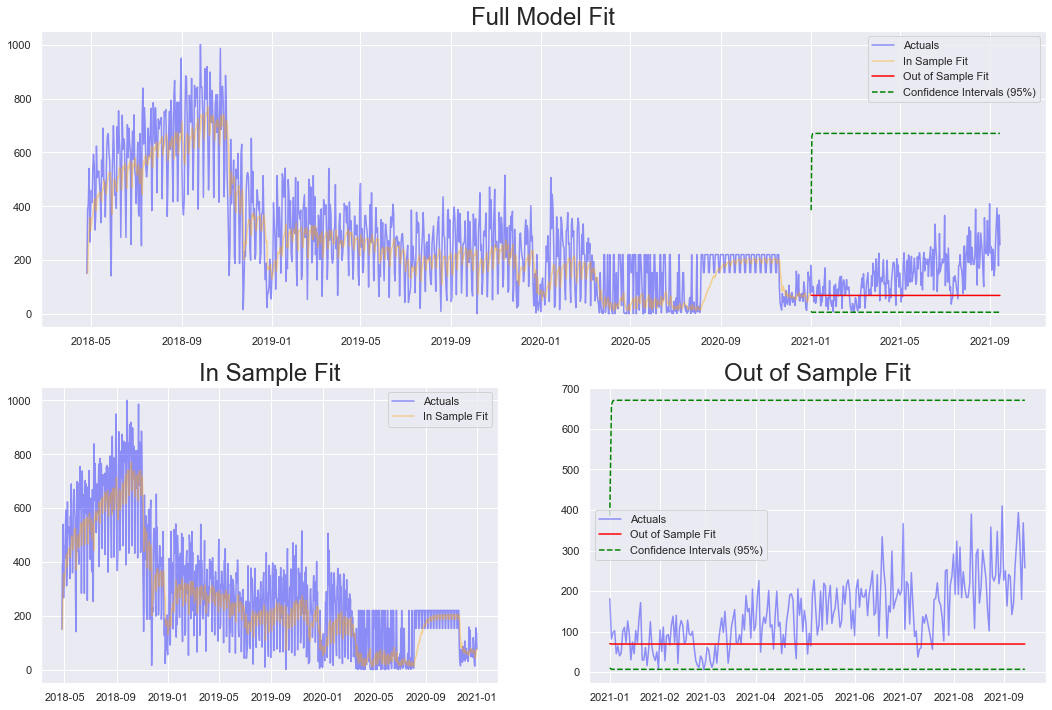

In [30]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred1_df["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred1_df.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred1_df.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred1_df.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred1_df.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred1_df.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred1_df.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred1_df.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [31]:
rmse_in = np.sqrt(mean_squared_error(y_true = pred1_df.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred1_df.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred1_df.loc[test_df.index]["Kwh"], 
                                      y_pred = pred1_df.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for Out Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 121.45990445090163
RMSE for Out Sample Fit - 112.67532409332762


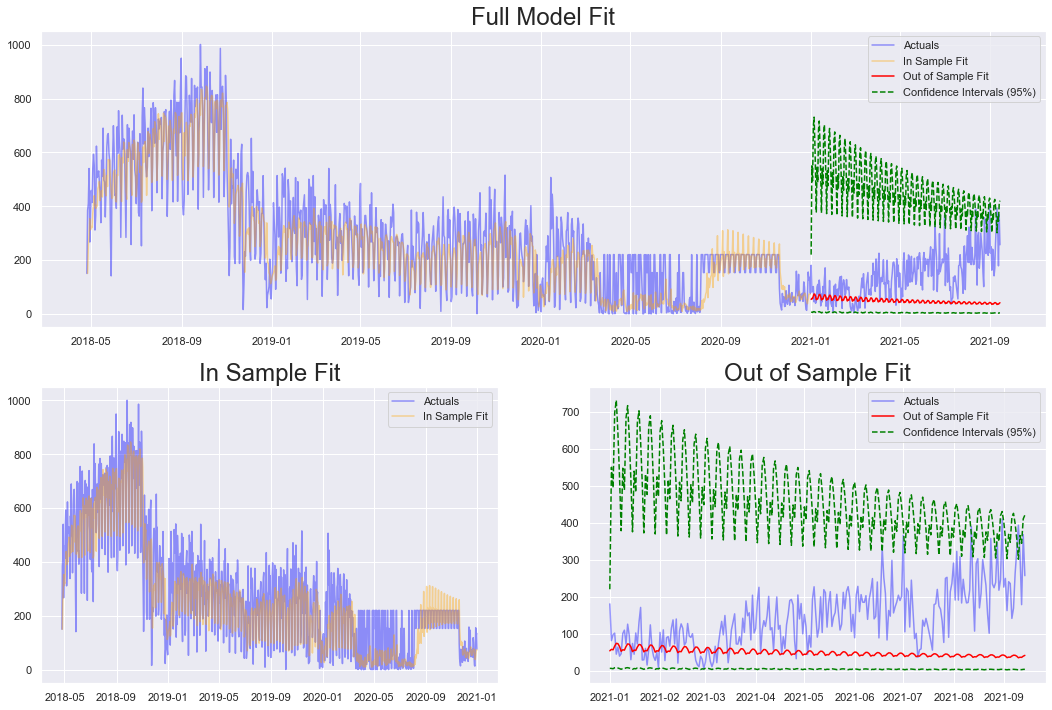

In [32]:
#SARMA Plot

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred1_df_seas["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df_seas.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred1_df_seas.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df_seas.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred1_df_seas.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [33]:
rmse_in = np.sqrt(mean_squared_error(y_true = pred1_df_seas.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred1_df_seas.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred1_df_seas.loc[test_df.index]["Kwh"], 
                                      y_pred = pred1_df_seas.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit Seasonal - {rmse_in}")
print(f"RMSE for Out Sample Fit Seasonal - {rmse_out}")

RMSE for In Sample Fit Seasonal - 98.12443475272765
RMSE for Out Sample Fit Seasonal - 130.41467115560985


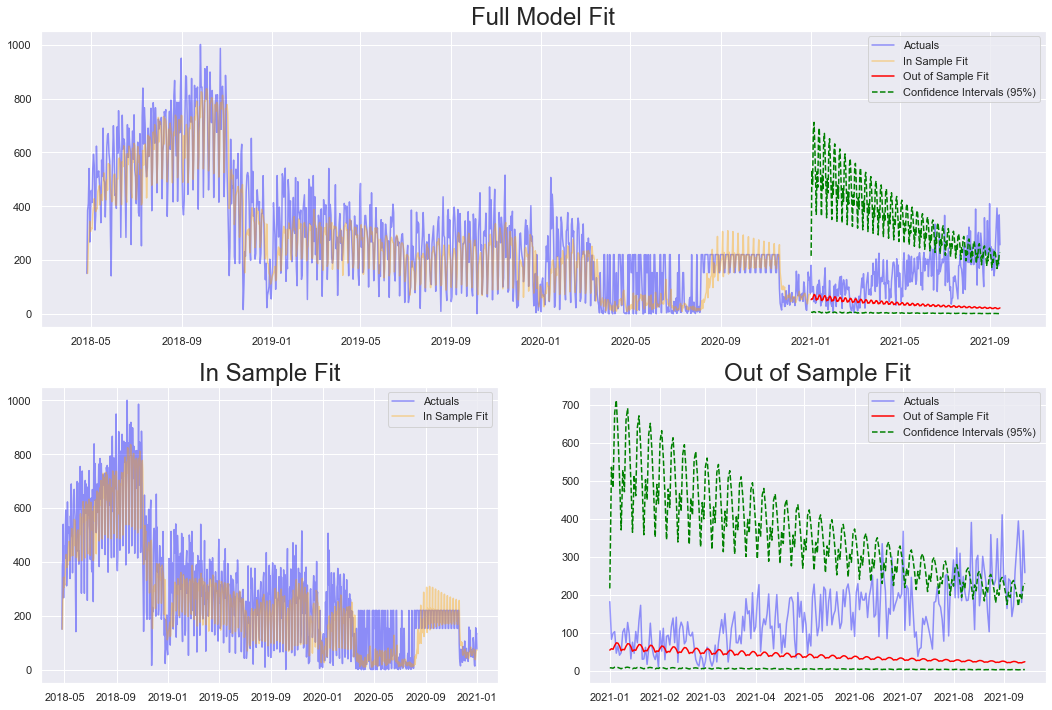

In [34]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred1_df_seas_exo["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df_seas_exo.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred1_df_seas_exo.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df_seas_exo.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred1_df_seas_exo.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [35]:
rmse_in = np.sqrt(mean_squared_error(y_true = pred1_df_seas_exo.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred1_df_seas_exo.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred1_df_seas_exo.loc[test_df.index]["Kwh"], 
                                      y_pred = pred1_df_seas_exo.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit Seasonal Exo - {rmse_in}")
print(f"RMSE for Out Sample Fit Seasonal Exo - {rmse_out}")


RMSE for In Sample Fit Seasonal Exo - 98.78253196020276
RMSE for Out Sample Fit Seasonal Exo - 140.5302671601634


# Train Once and Rolling Predictions

In [36]:
#ARMA

# Building a predictions dataframe for this technique
pred2_df = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred2_df["Kwh"] = data["Kwh"]
pred2_df["Kwh_1"] = pred2_df["Kwh"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred2_df["model_preds"] = model_fit.predict(start = train_df.index[1], end = test_df.index[-1])

# Getting Confidence Intervals for the transformed predictions on test set 
forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred2_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Kwh_log_diff"]
pred2_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Kwh_log_diff"]


# Building the In Sample and Out of Sample predictions using the formula shown in (*)
# Taking Exponent to invert logarithmic effect
pred2_df["model_preds_exp"] = np.exp(pred2_df["model_preds"].values)
pred2_df["model_preds_lower_exp"] = np.exp(list(pred2_df["model_preds_lower"].values))
pred2_df["model_preds_upper_exp"] = np.exp(list(pred2_df["model_preds_upper"].values))

# Multiplying with past lags to get the forecast and the confidence intervals
pred2_df["Kwh_preds"] = pred2_df["model_preds_exp"] * pred2_df["Kwh_1"]
pred2_df.at[test_df.index, "Kwh_preds_lower"] = pred2_df.loc[test_df.index]["model_preds_lower_exp"] * pred2_df.loc[test_df.index]["Kwh_1"]
pred2_df.at[test_df.index, "Kwh_preds_upper"] = pred2_df.loc[test_df.index]["model_preds_upper_exp"] * pred2_df.loc[test_df.index]["Kwh_1"]

In [37]:
#SARMA

# Building a predictions dataframe for this technique
pred2_df_seas = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred2_df_seas["Kwh"] = data["Kwh"]
pred2_df_seas["Kwh_1"] = pred2_df_seas["Kwh"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred2_df_seas["model_preds"] = seas_model_fit.predict(start = train_df.index[1], end = test_df.index[-1])

# Getting Confidence Intervals for the transformed predictions on test set 
forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred2_df_seas.at[test_df.index, "model_preds_lower"] = forecast_df["lower Kwh_log_diff"]
pred2_df_seas.at[test_df.index, "model_preds_upper"] = forecast_df["upper Kwh_log_diff"]


# Building the In Sample and Out of Sample predictions using the formula shown in (*)
# Taking Exponent to invert logarithmic effect
pred2_df_seas["model_preds_exp"] = np.exp(pred2_df_seas["model_preds"].values)
pred2_df_seas["model_preds_lower_exp"] = np.exp(list(pred2_df_seas["model_preds_lower"].values))
pred2_df_seas["model_preds_upper_exp"] = np.exp(list(pred2_df_seas["model_preds_upper"].values))

# Multiplying with past lags to get the forecast and the confidence intervals
pred2_df_seas["Kwh_preds"] = pred2_df_seas["model_preds_exp"] * pred2_df_seas["Kwh_1"]
pred2_df_seas.at[test_df.index, "Kwh_preds_lower"] = pred2_df_seas.loc[test_df.index]["model_preds_lower_exp"] * pred2_df_seas.loc[test_df.index]["Kwh_1"]
pred2_df_seas.at[test_df.index, "Kwh_preds_upper"] = pred2_df_seas.loc[test_df.index]["model_preds_upper_exp"] * pred2_df_seas.loc[test_df.index]["Kwh_1"]

In [38]:
#SARMAX

# Building a predictions dataframe for this technique
pred2_df_seas_exo = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred2_df_seas_exo["Kwh"] = data["Kwh"]
pred2_df_seas_exo["Kwh_1"] = pred2_df_seas_exo["Kwh"].shift(1)

# Predictions on transformed data over the full span of the dataset.
pred2_df_seas_exo["model_preds"] = seas_model_fit.predict(start = train_df.index[1], end = test_df.index[-1],exog=test_df_exo['IsWeekend'])

# Getting Confidence Intervals for the transformed predictions on test set 
forecast = seas_model_fit.get_forecast(len(test_df.index),exog=test_df_exo['IsWeekend'])
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred2_df_seas_exo.at[test_df.index, "model_preds_lower"] = forecast_df["lower Kwh_log_diff"]
pred2_df_seas_exo.at[test_df.index, "model_preds_upper"] = forecast_df["upper Kwh_log_diff"]


# Building the In Sample and Out of Sample predictions using the formula shown in (*)
# Taking Exponent to invert logarithmic effect
pred2_df_seas_exo["model_preds_exp"] = np.exp(pred2_df_seas_exo["model_preds"].values)
pred2_df_seas_exo["model_preds_lower_exp"] = np.exp(list(pred2_df_seas_exo["model_preds_lower"].values))
pred2_df_seas_exo["model_preds_upper_exp"] = np.exp(list(pred2_df_seas_exo["model_preds_upper"].values))

# Multiplying with past lags to get the forecast and the confidence intervals
pred2_df_seas_exo["Kwh_preds"] = pred2_df_seas_exo["model_preds_exp"] * pred2_df_seas_exo["Kwh_1"]
pred2_df_seas_exo.at[test_df.index, "Kwh_preds_lower"] = pred2_df_seas_exo.loc[test_df.index]["model_preds_lower_exp"] * pred2_df_seas_exo.loc[test_df.index]["Kwh_1"]
pred2_df_seas_exo.at[test_df.index, "Kwh_preds_upper"] = pred2_df_seas_exo.loc[test_df.index]["model_preds_upper_exp"] * pred2_df_seas_exo.loc[test_df.index]["Kwh_1"]

In [39]:

pred2_df.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103000,NaN,NaN
2018-04-27,409.963,385.389,-0.403356,NaN,NaN,0.668074,NaN,NaN,257.468355,NaN,NaN
2018-04-28,540.545,409.963,-0.313430,NaN,NaN,0.730935,NaN,NaN,299.656393,NaN,NaN
2018-04-29,267.643,540.545,-0.411003,NaN,NaN,0.662985,NaN,NaN,358.373037,NaN,NaN


In [40]:
pred2_df_seas.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103000,NaN,NaN
2018-04-27,409.963,385.389,-0.421087,NaN,NaN,0.656333,NaN,NaN,252.943567,NaN,NaN
2018-04-28,540.545,409.963,-0.322383,NaN,NaN,0.724420,NaN,NaN,296.985540,NaN,NaN
2018-04-29,267.643,540.545,-0.423352,NaN,NaN,0.654848,NaN,NaN,353.974722,NaN,NaN


In [41]:
pred2_df_seas_exo.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103000,NaN,NaN
2018-04-27,409.963,385.389,-0.421087,NaN,NaN,0.656333,NaN,NaN,252.943567,NaN,NaN
2018-04-28,540.545,409.963,-0.322383,NaN,NaN,0.724420,NaN,NaN,296.985540,NaN,NaN
2018-04-29,267.643,540.545,-0.423352,NaN,NaN,0.654848,NaN,NaN,353.974722,NaN,NaN


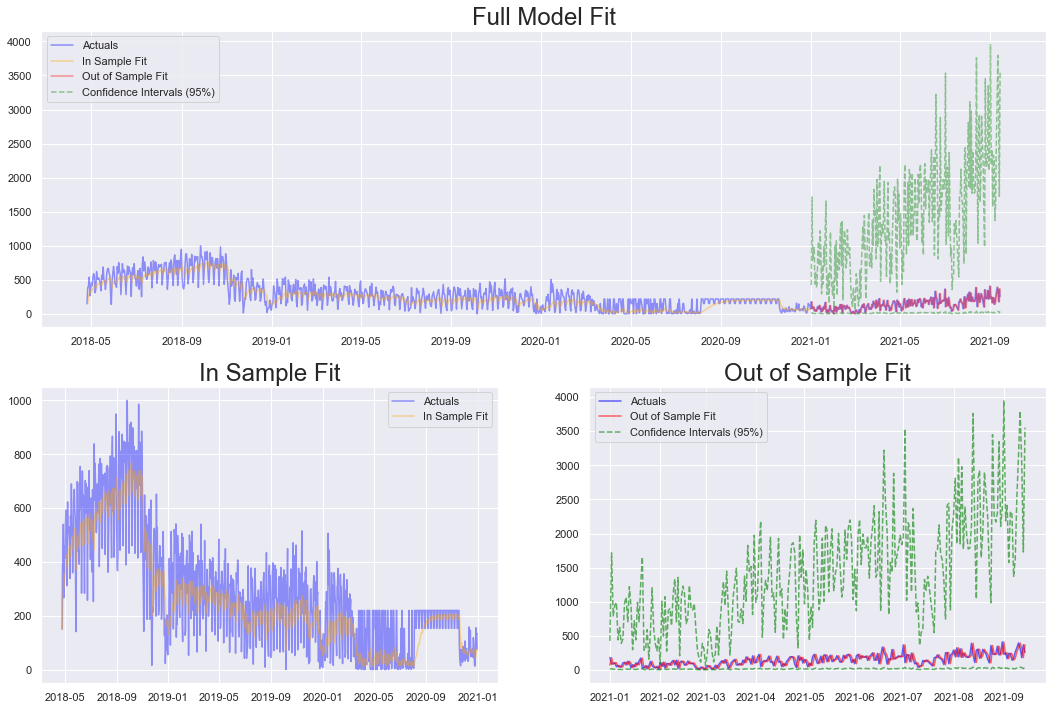

In [42]:
#ARMA

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred2_df["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred2_df.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred2_df.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.4)
plt.plot(pred2_df.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred2_df.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred2_df.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred2_df.loc[train_df.index]["Kwh_preds"], color = "orange", linestyle = "-", label = "In Sample Fit", alpha = 0.4)
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred2_df.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred2_df.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred2_df.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred2_df.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [43]:
#ARMA

rmse_in = np.sqrt(mean_squared_error(y_true = pred2_df.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred2_df.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred2_df.loc[test_df.index]["Kwh"], 
                                      y_pred = pred2_df.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for Out Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 121.45990445090163
RMSE for Out Sample Fit - 75.34923120459622


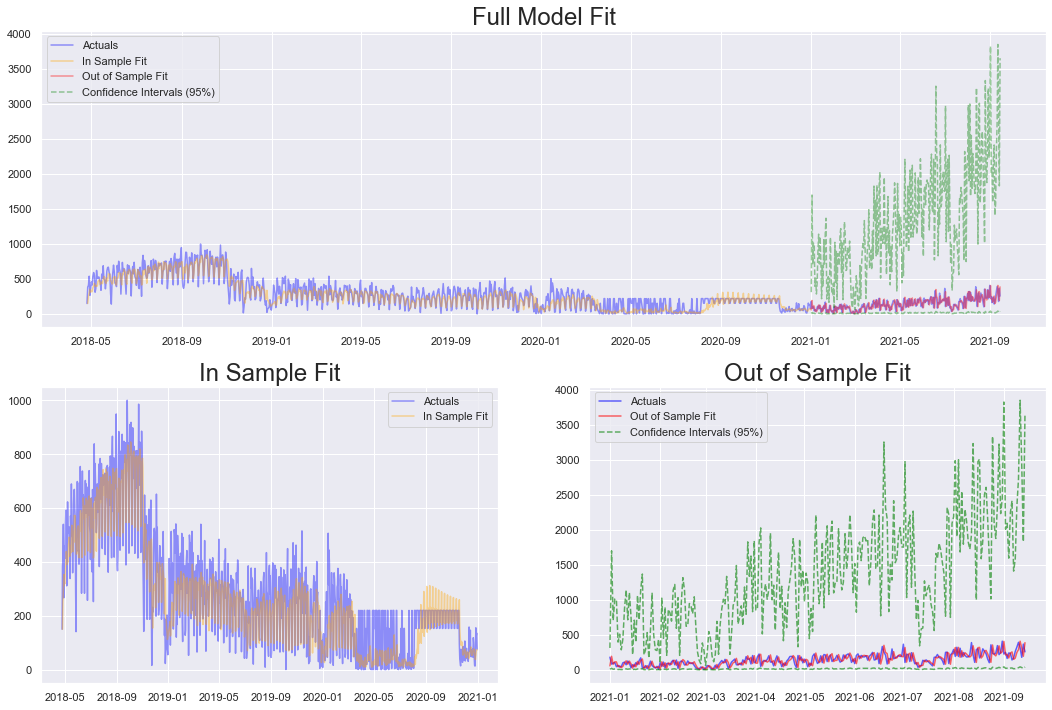

In [44]:
#SARMA

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred2_df_seas["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred2_df_seas.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.4)
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred2_df_seas.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred2_df_seas.loc[train_df.index]["Kwh_preds"], color = "orange", linestyle = "-", label = "In Sample Fit", alpha = 0.4)
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred2_df_seas.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [45]:
#SARMA

rmse_in = np.sqrt(mean_squared_error(y_true = pred2_df_seas.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred2_df_seas.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred2_df_seas.loc[test_df.index]["Kwh"], 
                                      y_pred = pred2_df_seas.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit Seasonal- {rmse_in}")
print(f"RMSE for Out Sample Fit Seasonal- {rmse_out}")

RMSE for In Sample Fit Seasonal- 98.12443475272765
RMSE for Out Sample Fit Seasonal- 75.88302927832405


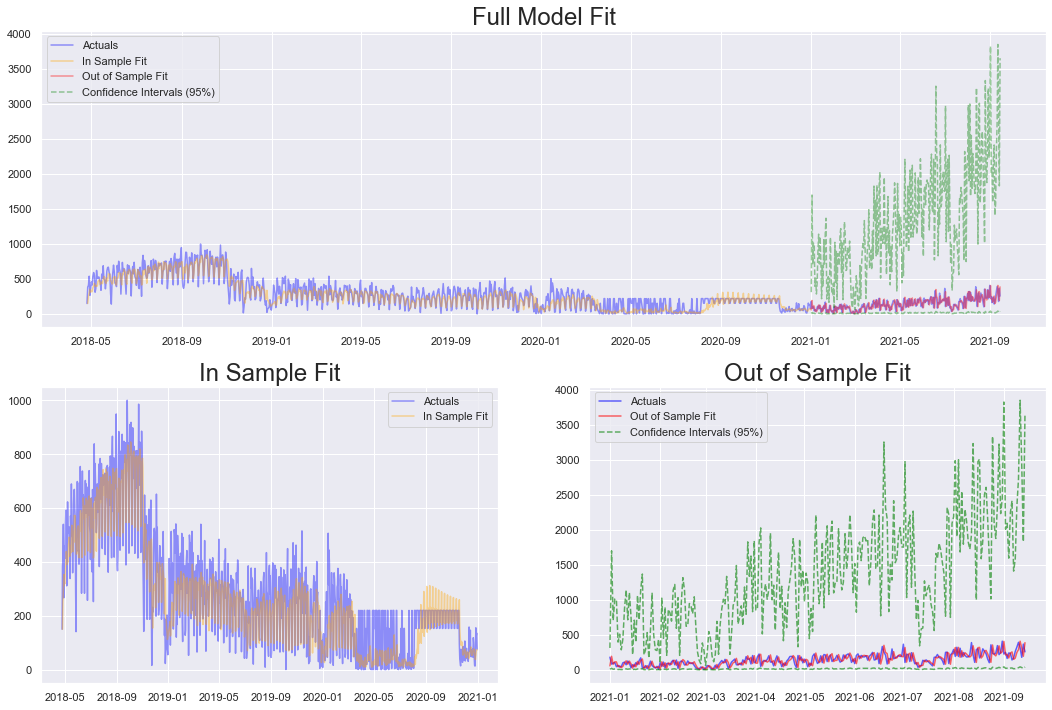

In [46]:
#SARMAX

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred2_df_seas_exo["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred2_df_seas_exo.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.4)
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred2_df_seas_exo.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred2_df_seas_exo.loc[train_df.index]["Kwh_preds"], color = "orange", linestyle = "-", label = "In Sample Fit", alpha = 0.4)
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred2_df_seas_exo.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [47]:
rmse_in = np.sqrt(mean_squared_error(y_true = pred2_df_seas_exo.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred2_df_seas_exo.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred2_df_seas_exo.loc[test_df.index]["Kwh"], 
                                      y_pred = pred2_df_seas_exo.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit Seasonal Exo - {rmse_in}")
print(f"RMSE for Out Sample Fit Seasonal Exo - {rmse_out}")

RMSE for In Sample Fit Seasonal Exo - 98.12443475272765
RMSE for Out Sample Fit Seasonal Exo - 75.88302927832405


# Rolling Training - Rolling Predictions

In [48]:
def get_model(rolling_train_df, last_idx, next_i):
    train_series = rolling_train_df.loc[:last_idx]["Kwh"]
    train_series = np.log(train_series)
    train_series = train_series.diff(1)
    flag = 0
    while(flag == 0):
        flag = 0
        try:
            rolling_model = SARIMAX(train_series.dropna(), order = (1, 0, 1))
            rolling_model_results = rolling_model.fit()
            flag = 1
        except:
            flag = 0
    
    rolling_pred = rolling_model_results.predict(start = test_df.index[next_i], end = test_df.index[next_i])
    
    rolling_forecast = rolling_model_results.get_forecast(1)
    rolling_forecast_df = rolling_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
    
    y_t_pred = (np.exp(rolling_pred.values[0]) * rolling_train_df.at[test_df.index[next_i], "Kwh_1"])
    y_t_pred_lower = (np.exp(rolling_forecast_df["lower Kwh"].values[0]) * rolling_train_df.at[test_df.index[next_i], "Kwh_1"])
    y_t_pred_upper = (np.exp(rolling_forecast_df["upper Kwh"].values[0]) * rolling_train_df.at[test_df.index[next_i], "Kwh_1"])
    
    return rolling_model_results, y_t_pred, y_t_pred_lower, y_t_pred_upper

In [49]:
#ARMA
# Building a predictions dataframe for this technique
pred3_df = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred3_df["Kwh"] = data["Kwh"]
pred3_df["Kwh_1"] = pred3_df["Kwh"].shift(1)

# Predictions on transformed data over the full training dataset and the first lag of the test dataset.
pred3_df["model_preds"] = model_fit.predict(start = train_df.index[1], end = test_df.index[0])

# Taking Exponent to invert logarithmic effect from predictions
pred3_df["model_preds_exp"] = np.exp(pred3_df["model_preds"].values)

# Building the In Sample Predictions
pred3_df.at[train_df.index, "Kwh_preds"] = pred3_df.loc[train_df.index]["model_preds_exp"] * pred3_df.loc[train_df.index]["Kwh_1"]
# pred3_df.at[train_df.index, "Kwh_preds"] = pred3_df.loc[train_df.index]["model_preds_exp"] * pred3_df.loc[train_df.index]["Kwh_1"]

# The prediction for the first testing lag is built here
last_train_idx = train_df.index[-1]
rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(pred3_df, last_train_idx, 0)
pred3_df.at[test_df.index[0], "Kwh_preds"] = y_t_pred
pred3_df.at[test_df.index[0], "Kwh_preds_lower"] = y_t_pred_lower
pred3_df.at[test_df.index[0], "Kwh_preds_upper"] = y_t_pred_upper

# This loop is used to get new models for each new lag that is added to the training set from the testing set.
for idx in range(len(test_df.index)-1):
    last_train_idx = test_df.index[idx]
    rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(pred3_df, last_train_idx, idx+1)
    pred3_df.at[test_df.index[idx+1], "Kwh_preds"] = y_t_pred
    pred3_df.at[test_df.index[idx+1], "Kwh_preds_lower"] = y_t_pred_lower
    pred3_df.at[test_df.index[idx+1], "Kwh_preds_upper"] = y_t_pred_upper

In [50]:
pred3_df.at[train_df.index, "Kwh_preds"] = pred3_df.loc[train_df.index]["model_preds_exp"] * pred3_df.loc[train_df.index]["Kwh_1"]
pred3_df.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103,NaN,NaN
2018-04-27,409.963,385.389,-0.403356,NaN,NaN,0.668074,NaN,NaN,257.468355,NaN,NaN
2018-04-28,540.545,409.963,-0.313430,NaN,NaN,0.730935,NaN,NaN,299.656393,NaN,NaN
2018-04-29,267.643,540.545,-0.411003,NaN,NaN,0.662985,NaN,NaN,358.373037,NaN,NaN


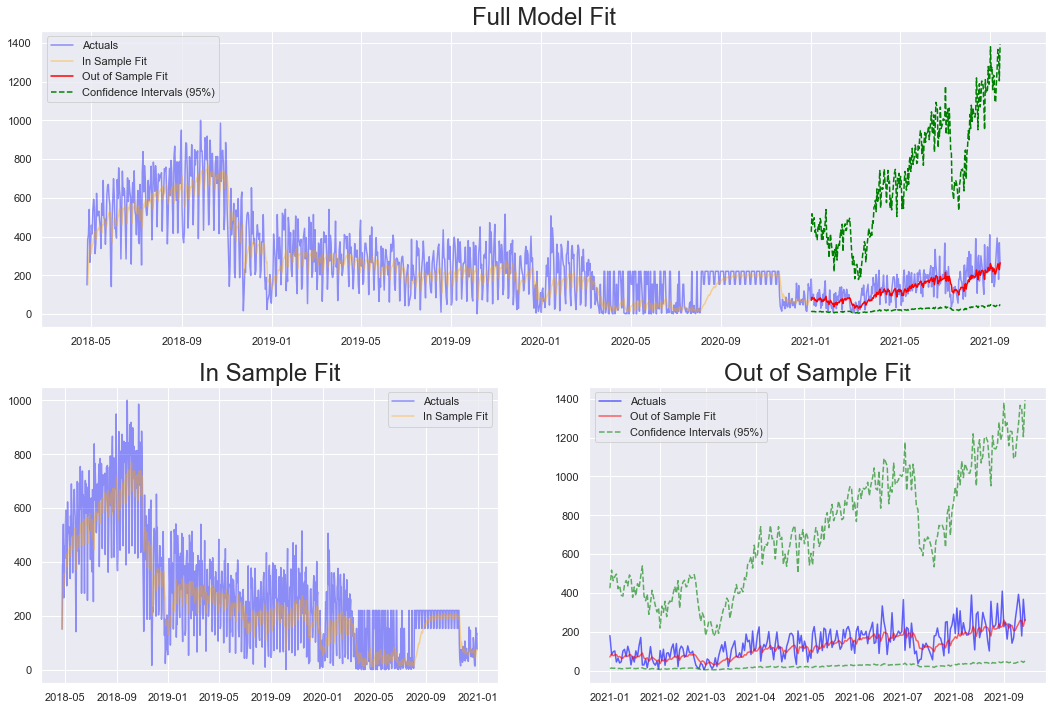

In [51]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred3_df["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred3_df.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred3_df.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred3_df.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred3_df.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred3_df.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred3_df.loc[train_df.index]["Kwh_preds"], color = "orange", linestyle = "-", label = "In Sample Fit", alpha = 0.4)
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred3_df.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred3_df.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred3_df.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred3_df.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [52]:
#ARMA
rmse_in = np.sqrt(mean_squared_error(y_true = pred3_df.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred3_df.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred3_df.loc[test_df.index]["Kwh"], 
                                      y_pred = pred3_df.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit - {rmse_in}")
print(f"RMSE for Out Sample Fit - {rmse_out}")

RMSE for In Sample Fit - 121.45990445090163
RMSE for Out Sample Fit - 61.53321544219035


In [53]:
#SARMA
pred3_df_seas = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred3_df_seas["Kwh"] = data["Kwh"]
pred3_df_seas["Kwh_1"] = pred3_df_seas["Kwh"].shift(1)

# Predictions on transformed data over the full training dataset and the first lag of the test dataset.
pred3_df_seas["model_preds"] = seas_model_fit.predict(start = train_df.index[1], end = test_df.index[0])

# Taking Exponent to invert logarithmic effect from predictions
pred3_df_seas["model_preds_exp"] = np.exp(pred3_df_seas["model_preds"].values)

# Building the In Sample Predictions
pred3_df_seas.at[train_df.index, "Kwh_preds"] = pred3_df_seas.loc[train_df.index]["model_preds_exp"] * pred3_df_seas.loc[train_df.index]["Kwh_1"]
# pred3_df_seas.at[train_df.index, "Kwh_preds"] = pred3_df_seas.loc[train_df.index]["model_preds_exp"] * pred3_df_seas.loc[train_df.index]["Kwh_1"]

# The prediction for the first testing lag is built here
last_train_idx = train_df.index[-1]
rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(pred3_df_seas, last_train_idx, 0)
pred3_df_seas.at[test_df.index[0], "Kwh_preds"] = y_t_pred
pred3_df_seas.at[test_df.index[0], "Kwh_preds_lower"] = y_t_pred_lower
pred3_df_seas.at[test_df.index[0], "Kwh_preds_upper"] = y_t_pred_upper

# This loop is used to get new models for each new lag that is added to the training set from the testing set.
for idx in range(len(test_df.index)-1):
    last_train_idx = test_df.index[idx]
    rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(pred3_df_seas, last_train_idx, idx+1)
    pred3_df_seas.at[test_df.index[idx+1], "Kwh_preds"] = y_t_pred
    pred3_df_seas.at[test_df.index[idx+1], "Kwh_preds_lower"] = y_t_pred_lower
    pred3_df_seas.at[test_df.index[idx+1], "Kwh_preds_upper"] = y_t_pred_upper

In [54]:
pred3_df_seas.at[train_df.index, "Kwh_preds"] = pred3_df_seas.loc[train_df.index]["model_preds_exp"] * pred3_df_seas.loc[train_df.index]["Kwh_1"]

In [55]:
pred3_df_seas.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103,NaN,NaN
2018-04-27,409.963,385.389,-0.421087,NaN,NaN,0.656333,NaN,NaN,252.943567,NaN,NaN
2018-04-28,540.545,409.963,-0.322383,NaN,NaN,0.724420,NaN,NaN,296.98554,NaN,NaN
2018-04-29,267.643,540.545,-0.423352,NaN,NaN,0.654848,NaN,NaN,353.974722,NaN,NaN


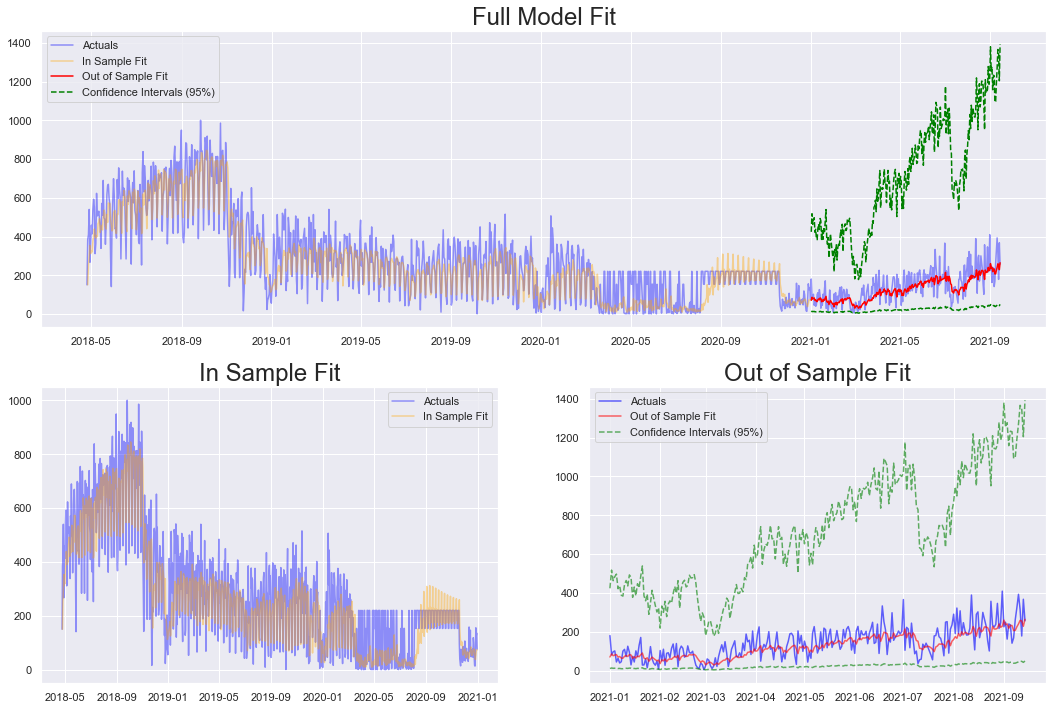

In [56]:
#SARMA
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred3_df_seas["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred3_df_seas.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred3_df_seas.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred3_df_seas.loc[train_df.index]["Kwh_preds"], color = "orange", linestyle = "-", label = "In Sample Fit", alpha = 0.4)
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred3_df_seas.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [57]:
#SARMA
rmse_in = np.sqrt(mean_squared_error(y_true = pred3_df_seas.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred3_df_seas.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred3_df_seas.loc[test_df.index]["Kwh"], 
                                      y_pred = pred3_df_seas.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit Seasonal- {rmse_in}")
print(f"RMSE for Out Sample Fit Seasonal- {rmse_out}")

RMSE for In Sample Fit Seasonal- 98.12443475272765
RMSE for Out Sample Fit Seasonal- 61.53321544219035


In [58]:
#SARMAX
pred3_df_seas_exo = pd.DataFrame(columns = ["Kwh", "Kwh_1",
                                   "model_preds", "model_preds_lower", "model_preds_upper", 
                                   "model_preds_exp", "model_preds_lower_exp", "model_preds_upper_exp", 
                                   "Kwh_preds", "Kwh_preds_lower", "Kwh_preds_upper"],
                        index = data.index)

# Storing the original series and one lagged version (y(t) and y(t-1))
pred3_df_seas_exo["Kwh"] = data["Kwh"]
pred3_df_seas_exo["Kwh_1"] = pred3_df_seas_exo["Kwh"].shift(1)

# Predictions on transformed data over the full training dataset and the first lag of the test dataset.
pred3_df_seas_exo["model_preds"] = seas_model_fit.predict(start = train_df.index[1], end = test_df.index[0],exog=test_df_exo['IsWeekend'])

# Taking Exponent to invert logarithmic effect from predictions
pred3_df_seas_exo["model_preds_exp"] = np.exp(pred3_df_seas_exo["model_preds"].values)

# Building the In Sample Predictions
pred3_df_seas_exo.at[train_df.index, "Kwh_preds"] = pred3_df_seas_exo.loc[train_df.index]["model_preds_exp"] * pred3_df_seas_exo.loc[train_df.index]["Kwh_1"]
# pred3_df_seas_exo.at[train_df.index, "Kwh_preds"] = pred3_df_seas_exo.loc[train_df.index]["model_preds_exp"] * pred3_df_seas_exo.loc[train_df.index]["Kwh_1"]

# The prediction for the first testing lag is built here
last_train_idx = train_df.index[-1]
rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(pred3_df_seas_exo, last_train_idx, 0)
pred3_df_seas_exo.at[test_df.index[0], "Kwh_preds"] = y_t_pred
pred3_df_seas_exo.at[test_df.index[0], "Kwh_preds_lower"] = y_t_pred_lower
pred3_df_seas_exo.at[test_df.index[0], "Kwh_preds_upper"] = y_t_pred_upper

# This loop is used to get new models for each new lag that is added to the training set from the testing set.
for idx in range(len(test_df.index)-1):
    last_train_idx = test_df.index[idx]
    rolling_model, y_t_pred, y_t_pred_lower, y_t_pred_upper = get_model(pred3_df_seas_exo, last_train_idx, idx+1)
    pred3_df_seas_exo.at[test_df.index[idx+1], "Kwh_preds"] = y_t_pred
    pred3_df_seas_exo.at[test_df.index[idx+1], "Kwh_preds_lower"] = y_t_pred_lower
    pred3_df_seas_exo.at[test_df.index[idx+1], "Kwh_preds_upper"] = y_t_pred_upper

In [59]:
pred3_df_seas_exo.at[train_df.index, "Kwh_preds"] = pred3_df_seas_exo.loc[train_df.index]["model_preds_exp"] * pred3_df_seas_exo.loc[train_df.index]["Kwh_1"]

In [60]:
pred3_df_seas_exo.head()

,Kwh,Kwh_1,model_preds,model_preds_lower,model_preds_upper,model_preds_exp,model_preds_lower_exp,model_preds_upper_exp,Kwh_preds,Kwh_preds_lower,Kwh_preds_upper
Date,,,,,,,,,,,
2018-04-25,151.103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-26,385.389,151.103,0.000000,NaN,NaN,1.000000,NaN,NaN,151.103,NaN,NaN
2018-04-27,409.963,385.389,-0.421087,NaN,NaN,0.656333,NaN,NaN,252.943567,NaN,NaN
2018-04-28,540.545,409.963,-0.322383,NaN,NaN,0.724420,NaN,NaN,296.98554,NaN,NaN
2018-04-29,267.643,540.545,-0.423352,NaN,NaN,0.654848,NaN,NaN,353.974722,NaN,NaN


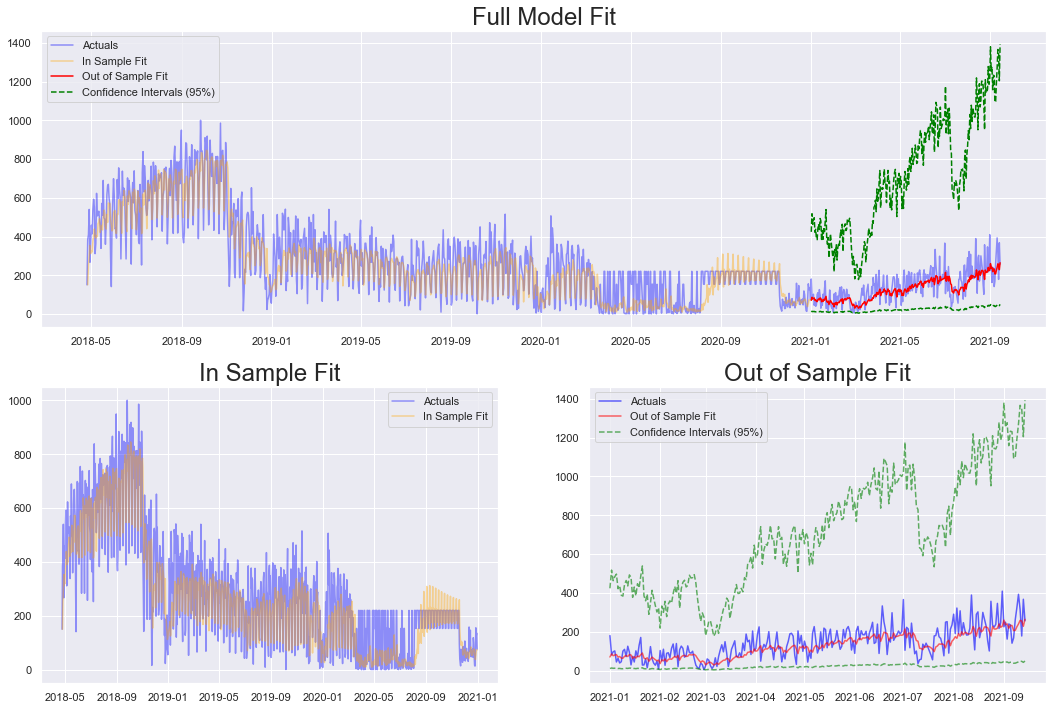

In [61]:
#SARMAX
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred3_df_seas_exo["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred3_df_seas_exo.loc[train_df.index]["Kwh_preds"], color = "orange", alpha = 0.4, linestyle = "-", label = "In Sample Fit")
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)")
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--")
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred3_df_seas_exo.loc[train_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred3_df_seas_exo.loc[train_df.index]["Kwh_preds"], color = "orange", linestyle = "-", label = "In Sample Fit", alpha = 0.4)
plt.title("In Sample Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred3_df_seas_exo.loc[test_df.index]["Kwh_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

In [62]:
#SARMAX
rmse_in = np.sqrt(mean_squared_error(y_true = pred3_df_seas_exo.loc[train_df.index[1]:train_df.index[-1]]["Kwh"], 
                                     y_pred = pred3_df_seas_exo.loc[train_df.index[1]:train_df.index[-1]]["Kwh_preds"]))

rmse_out = np.sqrt(mean_squared_error(y_true = pred3_df_seas_exo.loc[test_df.index]["Kwh"], 
                                      y_pred = pred3_df_seas_exo.loc[test_df.index]["Kwh_preds"]))

print(f"RMSE for In Sample Fit Seasonal- {rmse_in}")
print(f"RMSE for Out Sample Fit Seasonal- {rmse_out}")

RMSE for In Sample Fit Seasonal- 98.12443475272765
RMSE for Out Sample Fit Seasonal- 61.53321544219035
